<a href="https://colab.research.google.com/github/toussaintma/neuralnetworksfromzerotohero/blob/main/walkthrough_makemore_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# data and code at https://github.com/karpathy/makemore
# course at https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2&t=11s
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# Building makemore Part 5: Wavenet
# wavenet paper: https://arxiv.org/abs/1609.03499

--2023-07-19 12:19:24--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-07-19 12:19:24 (13.4 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_words = pd.read_csv('names.txt', header=None, names=['name'])
words = df_words['name'].values.tolist()
df_words.shape

(32033, 1)

In [4]:
chars = sorted(list(set("".join(words))))
stoi = {c : i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i + 1: chars[i] for i in range(len(chars))}
itos[0] = '.'

In [14]:
block_size = 8

In [15]:
def build_dataset(word):
  X = []
  Y = []
  for w in words[:]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), ' --> ', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [36]:
for i in range(len(Xtr[:20])):
  print("".join(list(map(lambda x: itos[x], Xtr[i].tolist()))) + ' ---> ' + itos[Ytr[i].item()])

........ ---> l
.......l ---> y
......ly ---> n
.....lyn ---> d
....lynd ---> e
...lynde ---> n
..lynden ---> .
........ ---> b
.......b ---> a
......ba ---> y
.....bay ---> l
....bayl ---> e
...bayle ---> r
..bayler ---> .
........ ---> t
.......t ---> r
......tr ---> e
.....tre ---> s
....tres ---> .
........ ---> i


In [110]:
n_embd = 10
n_hidden = 68
vocab_size = 27
lossi = []
max_steps = 20000
batch_size = 32

class FlattenConsecutive(torch.nn.Module):
  def __init__(self, n):
    super().__init__()
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(dim = 1)
    self.out = x
    return self.out

class BatchNorm1d(torch.nn.Module):
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    super().__init__()
    self.eps = eps
    self.momentum = momentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim = True)
      xvar = x.var(dim, keepdim = True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x.mean()
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x.var()
    return self.out

    def parameters(self):
      return [self.gamma, self.beta]

    def train(self):
      self.training = True

    def eval(self):
      self.training = False

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), nn.Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), nn.Tanh(),
    FlattenConsecutive(2), nn.Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), nn.Tanh(),
    FlattenConsecutive(2), nn.Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
)

with torch.no_grad():
  model[13].weight *= 0.01

parameters = [p for p in model.parameters()]

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

21989


In [49]:
#ix = torch.randint(0, Xtr.shape[0], (4,))
#Xb, Yb = Xtr[ix], Ytr[ix]
#logits = model(Xb)
#print(Xb.shape)
#Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  3,  1, 20,  8, 18, 25, 14]])

In [102]:
# (1,2) (3,4) (5,6) (7,8)
f = torch.randn(4, 8, 10)
e = f.view(4, 4, 20)
explicit = torch.cat((f[:, ::2, :], f[:, 1::2, :]), dim=2)
e.shape, explicit.shape, (e == explicit).all()

(torch.Size([4, 4, 20]), torch.Size([4, 4, 20]), tensor(True))

In [111]:
model.train()
for i in range(max_steps):
  # mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]


  # Forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 15000 else 0.01

  for p in parameters:
    p.data += -lr * p.grad

  # stats
  if (i % 1000 == 0):
    print(F'step:{i:7d}/{max_steps:7d} loss:{loss.item():.4f}')
  lossi.append(loss.log10().item())

step:      0/  20000 loss:3.3266
step:   1000/  20000 loss:2.4286
step:   2000/  20000 loss:2.6566
step:   3000/  20000 loss:2.3601
step:   4000/  20000 loss:2.1226
step:   5000/  20000 loss:2.4756
step:   6000/  20000 loss:2.4841
step:   7000/  20000 loss:2.1672
step:   8000/  20000 loss:2.3735
step:   9000/  20000 loss:2.1099
step:  10000/  20000 loss:2.0867
step:  11000/  20000 loss:2.6538
step:  12000/  20000 loss:2.1320
step:  13000/  20000 loss:1.9355
step:  14000/  20000 loss:2.3905
step:  15000/  20000 loss:2.3441
step:  16000/  20000 loss:2.2099
step:  17000/  20000 loss:1.8831
step:  18000/  20000 loss:2.0488
step:  19000/  20000 loss:2.3010


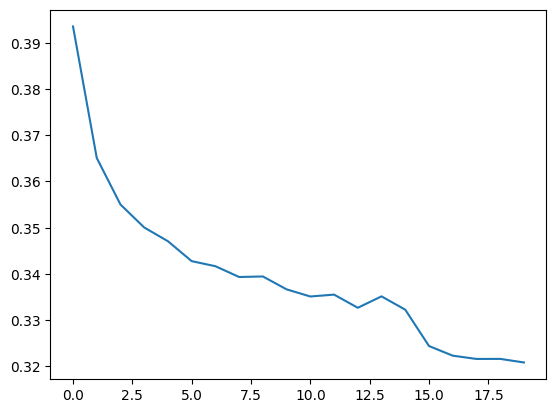

In [112]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [113]:
model.eval()

Sequential(
  (0): Embedding(27, 10)
  (1): FlattenConsecutive()
  (2): Linear(in_features=20, out_features=68, bias=False)
  (3): BatchNorm1d()
  (4): Tanh()
  (5): FlattenConsecutive()
  (6): Linear(in_features=136, out_features=68, bias=False)
  (7): BatchNorm1d()
  (8): Tanh()
  (9): FlattenConsecutive()
  (10): Linear(in_features=136, out_features=68, bias=False)
  (11): BatchNorm1d()
  (12): Tanh()
  (13): Linear(in_features=68, out_features=27, bias=True)
)

In [114]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.710339307785034
val 2.710339307785034


In [115]:
def sample():
  output = []
  context = [0] * block_size
  sample = 0

  while True:
    logits = model(torch.tensor([context])) # 1, 3, 10
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1).item()
    context = context[1:] + [ix]
    output.append(ix)
    if ix == 0:
      break
  return output

In [116]:
for j in range(10):
  print(''.join([itos[i] for i in sample()]))

dasbynakhina.
finttsjataustlitstn.
jikajalsanjycaswuzsmari.
raxlzjanchaitanjyanshathreantha.
hllisiansal.
danyamaja.
cphrantenthiazlynnzelorltynasshahthiccianemuez.
nahalann.
marottyo.
lbiasteidlolehkahanamaineheq.
